In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
print('mango disease')

In [1]:
!rm -rf /kaggle/working/*


In [2]:
!ls /kaggle/working


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices("GPU"))


2026-01-07 07:21:29.631541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767770489.652923    1942 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767770489.659632    1942 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767770489.678143    1942 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767770489.678164    1942 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767770489.678167    1942 computation_placer.cc:177] computation placer alr

TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [5]:
class Config:
    DATASET_PATH = "/kaggle/input/mango-leaf-dataset/mango_dataset"

    IMG_SIZE = 224
    BATCH_SIZE = 32
    EPOCHS = 40

    LR = 3e-5
    DROPOUT = 0.3

    MODEL_DIR = "mango_disease_tf"
    MODEL_KERAS = "mango_disease.keras"

cfg = Config()


In [6]:
def load_data(base_path):
    images, labels, class_names = [], [], []

    for idx, cls in enumerate(sorted(os.listdir(base_path))):
        cls_path = os.path.join(base_path, cls)
        if not os.path.isdir(cls_path):
            continue

        class_names.append(cls)

        for f in os.listdir(cls_path):
            if f.lower().endswith((".jpg", ".png", ".jpeg")):
                img = keras.utils.load_img(
                    os.path.join(cls_path, f),
                    target_size=(cfg.IMG_SIZE, cfg.IMG_SIZE)
                )
                img = keras.utils.img_to_array(img)
                images.append(img)
                labels.append(idx)

    X = np.array(images, dtype="float32") / 255.0
    y = np.array(labels)

    return X, y, class_names

X, y, CLASS_NAMES = load_data(cfg.DATASET_PATH)
NUM_CLASSES = len(CLASS_NAMES)

print("Classes:", CLASS_NAMES)
print("Total images:", len(X))


Classes: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']
Total images: 4000


In [7]:
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.15, stratify=y_tmp, random_state=42
)

print("Train:", len(X_train))
print("Val:", len(X_val))
print("Test:", len(X_test))


Train: 2890
Val: 510
Test: 600


In [8]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),   # ~9 degrees only
])


I0000 00:00:1767771278.505141    1942 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767771278.508948    1942 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [9]:
from tensorflow.keras.applications import EfficientNetB0

inputs = layers.Input(shape=(cfg.IMG_SIZE, cfg.IMG_SIZE, 3))

x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)

base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=x
)

# 🔥 IMPORTANT: UNFREEZE BACKBONE
base_model.trainable = True

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(cfg.DROPOUT)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,384,683 (16.73 MB)

 Trainable params: 4,340,100 (16.56 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [10]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=cfg.LR),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [11]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        cfg.MODEL_KERAS,
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    )
]


In [12]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=cfg.EPOCHS,
    batch_size=cfg.BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/40


E0000 00:00:1767771533.757659    1942 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1767771538.798478    2061 cuda_dnn.cc:529] Loaded cuDNN version 91002


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.3074 - loss: 2.0883
Epoch 1: val_accuracy improved from -inf to 0.12353, saving model to mango_disease.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 73s 392ms/step - accuracy: 0.3094 - loss: 2.0818 - val_accuracy: 0.1235 - val_loss: 2.1485 - learning_rate: 3.0000e-05
Epoch 2/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.8174 - loss: 0.5906
Epoch 2: val_accuracy did not improve from 0.12353
91/91 ━━━━━━━━━━━━━━━━━━━━ 31s 337ms/step - accuracy: 0.8177 - loss: 0.5895 - val_accuracy: 0.1235 - val_loss: 2.2917 - learning_rate: 3.0000e-05
Epoch 3/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9141 - loss: 0.2974
Epoch 3: val_accuracy improved from 0.12353 to 0.19412, saving model to mango_disease.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 32s 354ms/step - accuracy: 0.9142 - loss: 0.2971 - val_accuracy: 0.1941 - val_loss: 2.2119 - learning_rate: 3.0000e-05
Epoch 4/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9481 - loss: 0.17

In [13]:
model = keras.models.load_model(cfg.MODEL_KERAS)

pred_probs = model.predict(X_test)
preds = np.argmax(pred_probs, axis=1)

print(classification_report(
    y_test, preds, target_names=CLASS_NAMES, digits=3
))


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step
                  precision    recall  f1-score   support

     Anthracnose      0.987     1.000     0.993        75
Bacterial Canker      0.987     1.000     0.993        75
  Cutting Weevil      1.000     1.000     1.000        75
        Die Back      1.000     1.000     1.000        75
      Gall Midge      0.986     0.973     0.980        75
         Healthy      1.000     1.000     1.000        75
  Powdery Mildew      1.000     0.987     0.993        75
     Sooty Mould      0.987     0.987     0.987        75

        accuracy                          0.993       600
       macro avg      0.993     0.993     0.993       600
    weighted avg      0.993     0.993     0.993       600



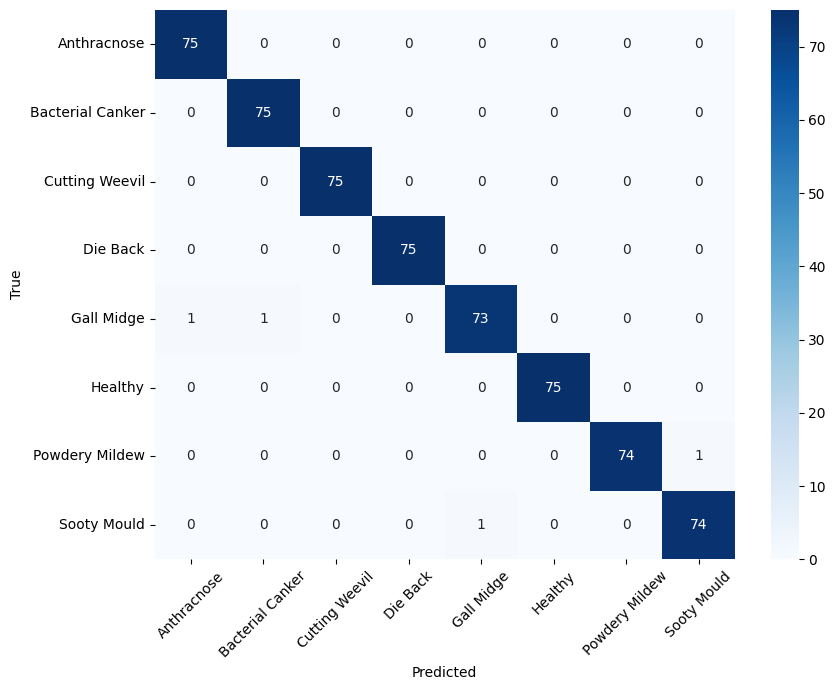

In [14]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(9,7))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
model.export(cfg.MODEL_DIR)
print("SavedModel exported:", cfg.MODEL_DIR)


INFO:tensorflow:Assets written to: mango_disease_tf/assets


INFO:tensorflow:Assets written to: mango_disease_tf/assets


Saved artifact at 'mango_disease_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')]
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  140345668927312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140345668924240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338269061968: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140338269071760: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140345169778192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140345169774544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140345169774352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140345169777040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140345169779728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140345169773584: TensorSpec(shape=(), dtype=tf.resource, name

In [16]:
import shutil
shutil.make_archive(cfg.MODEL_DIR, "zip", cfg.MODEL_DIR)


'/kaggle/working/mango_disease_tf.zip'